In [1379]:
from math import sqrt
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

## Utils

In [1623]:
def GS_mean(f, eva_count = 20):
    arr = []
    for i in range(eva_count):
        arr.append(GS(f))
    return np.array(arr).mean()

In [1624]:
# line search

def GS(f, xs=0, s=1, mu=0, sigma=2):
# optimization method used = Integrated Bracketing and Golden Section Algorithm
    
    
    # 1 Initialize randomly
    x1 = xs + np.random.normal(mu, sigma, 1)[0]
    tau = 0.618

    ep_R = 1e-7
    ep_abs = 1e-6

    # 2 Evaluate f2
    x2 = x1 + s

    # 3 Check and invert axis
    if f(x2) < f(x1):
        f2 = f(x1 + s)
    else:
        temp = x1
        x1 = x2
        x2 = temp
        s = -s
        f2 = f(x1 + s)

    # 4 Evaluate f4 based on tau

    x2s = []
    f2s = []
    x4s = []
    f4s = []

    s = s / tau
    x4 = x2 + s
    f4 = f(x4)

    x4s.append(x4)
    f4s.append(f(x4))

    # 5 6 Check and make sure f4 > f2
    while f4 <= f2:
        x1 = x2
        x2 = x4
        s = s / tau
        x4 = x2 + s
        f4 = f(x4)
        x4s.append(x4)
        f4s.append(f(x4))
    i = 0

    x3s = []
    f3s = []

    # do
    x3 = tau * x4 + (1 - tau) * x1
    f3 = f(x3)
    x3s.append(x3)
    f3s.append(f3)

    f_new = (f(x1) + f(x2) + f(x3))/3
    f_old = f_new+1

    while (abs(x1 - x3) > ep_R * abs(x2) + ep_abs) and (abs(f_new - f_old) > ep_R*f(x2) + ep_abs):

        # 8 Loop on
        if (f2 < f3):
            x4 = x1
            x1 = x3
        else:
            x1 = x2
            x2 = x3
            f2 = f3

        # 7 Evaluate f3
        x3 = tau * x4 + (1 - tau) * x1
        f3 = f(x3)
        x3s.append(x3)
        f3s.append(f3)
        f_old = f_new
        f_new = (f(x1) + f(x2) + f(x3)) / 3
        i += 1
        
    return x2

In [1452]:
def normalize(v):
    dim = len(v)
    norm = np.linalg.norm(v)
    return [v[i]/norm for i in range(dim)]


In [1642]:
"""
Input:
    func: Function need to be optimized
    init_pt: Initial point in n dimension
    fprime: Derivative function
    optimizer: choice from [steepest descent, conjugate gradient]
    x_opt: mathmatical optimum input
    f_opt: mathmatical optimum value
    
    eva_count: evaluate n times. Default: 100
    f_tol: function value tolerance, used in stop criterion. Default: 0.001
    avg_linesearch: set 1 to use average of 100 Golden Section line search results. Default: 0
    verbose: set 1 to print out variables for debugging. Default: 0
    plot: set 1 to plot estimated distribution and box plot of X error, function value error, time consumed.

Output:
    x_errs: List of errors between optimum and estimated X for every eva_count samples
    f_errs: List of errors between optimum and estimated function values for every eva_count samples
    iters: List of iteration number for every eva_count samples
    times: List of times in milliseconds for every eva_count samples

"""

def evaluate(func, init_pt, fprime, optimizer, x_opt, f_opt, CG_iter=2, eva_count=30, f_tol=0.001, avg_linesearch=0, verbose=0, plot=0):
    dim = len(x_opt)
    fs = []
    xs = []
    x_errs = []
    f_errs = []
    iters = []
    times = []
    for i in range(eva_count):
#         init_pt_r = init_pt + np.random.normal(0, 5, 1)[0]
        start = time.time()
        x, f, iter_count = optimizer(func, init_pt, fprime, CG_iter, verbose, avg_linesearch, f_tol=f_tol)
        end = time.time()
        x_err = np.linalg.norm(x - x_opt)
        f_err = np.linalg.norm(f - f_opt)
        times.append(abs(start - end)*1000)
        xs.append(x)
        fs.append(f)
        x_errs.append(x_err)
        f_errs.append(f_err)
        iters.append(iter_count)

    if plot==1:
        fig = plt.figure(figsize=(12, 20))
        fig.suptitle('Scores', fontsize=20)

        plt.subplot(4, 2, 1)
        u = np.mean(x_errs)
        sig = np.mean(x_errs)
        x = np.linspace(u - 3 * sig, u + 3 * sig, 100)
        plt.title('Errors Normal Distribution')
        plt.plot(x, mlab.normpdf(x, u, sig))

        plt.subplot(4, 2, 2)
        plt.boxplot(x_errs, notch=True)
        plt.title('Errors Box Plot')

        plt.subplot(4, 2, 3)
        u = np.mean(fs)
        sig = np.mean(fs)
        x = np.linspace(u - 3 * sig, u + 3 * sig, 100)
        plt.title('Function Values Normal Distribution')
        plt.plot(x, mlab.normpdf(x, u, sig))

        plt.subplot(4, 2, 4)
        plt.boxplot(fs, notch=True)
        plt.title('Function Values Box Plot')

        plt.subplot(4, 2, 5)
        u = np.mean(times)
        sig = np.mean(times)
        x = np.linspace(u - 3 * sig, u + 3 * sig, 100)
        plt.title('Times Normal Distribution')
        plt.plot(x, mlab.normpdf(x, u, sig))

        plt.subplot(4, 2, 6)
        plt.boxplot(times, notch=True)
        plt.title('Times Box Plot')

        plt.show()
        
    return x_errs, f_errs, iters, times

## Steepest Descent

In [1567]:
def steepest_descent(func, x0, fprime, CG_iter=2, verbose=0, avg_linesearch=0, x_tol=0.0005, f_tol=0.0001, ep_R=1e-7, ep_abs=1e-6):
    
    iter_count = 0
    xk = x0
    dim = len(xk)
    gk = [fprime[i](xk) for i in range(dim)]
    dk = normalize([-gk[i] for i in range(dim)])

    f_old = func(xk)
    f_new = f_old+1

    while(abs(f_new-f_old) > f_tol):

        f_old = func(xk)

        f_a = lambda alpha: func([xk[i]+ alpha*dk[i] for i in range(dim)])
        if avg_linesearch == 1:
            alpha_k = GS_mean(f_a)
        else:
            alpha_k = GS(f_a)
        

        xk1 = xk + np.dot(alpha_k,dk)
        f_new = func(xk1)

        xk = xk1
        iter_count += 1

    x_final = xk

    if(verbose == 1):
        print('\nResult:', x_final, '%.6f' %func(x_final), iter_count)
    return x_final, func(x_final), iter_count
    

In [1611]:
x0 = [1,3]
fprime = [lambda x: 2.0*x[0] , lambda x: 8.0*x[1]]
func = lambda x: x[0]**2.0 + 4*x[1]**2.0

steepest_descent(func, x0, fprime, verbose=1, f_tol=0.01)


Result: [ 0.74872445 -0.01530655] 0.561525 2


(array([ 0.74872445, -0.01530655]), 0.5615254701643274, 2)

In [1627]:
x0 = [-1,1]
RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]

steepest_descent(RosenBrock, x0, fprime, verbose=1, f_tol=0.0001, avg_linesearch=1)


Result: [0.00251909 1.        ] 100.993699 181


(array([0.00251909, 1.        ]), 100.99369900429545, 181)

## Conjugate Gradient

In [1695]:
def conjugate_gradients(func, x0, fprime, CG_iter=2, verbose = 0, avg_linesearch=0, x_tol = 0.0005, f_tol = 0.0001, ep_R = 1e-7, ep_abs = 1e-6):

    #student code goes here:
    xk = x0
    x_step = []
    x_step.append(xk)

    dim = len(xk)
    gk = [fprime[i](xk) for i in range(dim)]
    dk = normalize([-gk[i] for i in range(dim)])

#     print('xk', xk)
#     print('dk', dk)

    iter_count = 0
    f_old = func(xk)
    f_new = f_old + 1


    while(abs(f_new-f_old) > f_tol): # ep_R*abs(f_old) + ep_abs):

        f_old = func(xk)

        for j in range(CG_iter):


            f_a = lambda alpha: func([xk[i]+ alpha*dk[i] for i in range(dim)])
            # argmin alpha by GS line search
            if avg_linesearch == 1:
                alpha_k = GS_mean(f_a)
            else:
                alpha_k = GS(f_a)
#             print('\nalpha:%.9f' % alpha_k)
            xk1 = xk + np.dot(alpha_k,dk)
#             print('xk1', xk1)
#             print('f(xk1)', func(xk1))
            gk1 = [fprime[i](xk1) for i in range(dim)]
            beta_k = np.dot(gk1,gk1)/np.dot(gk,gk)
#             print('beta:%.9f' % beta_k)

            dk1 = normalize([-gk1[i] for i in range(dim)] + np.dot(beta_k,dk))
#             print('dk1', dk1)

            dk = dk1
            x_step.append(xk1)
            xk = xk1
            gk = gk1

        f_new = func(xk1)
        x_final = xk
        

        if(f_new >= 5*f_old):
            if(verbose == 1):
                print("\nEarly Stopping!")
            if(len(x_step)>2):
                x_final = x_step[len(x_step)-2]
            break

        iter_count += 1
    if(verbose == 1):
        print('\nResult:', x_final, '%.6f' %func(x_final), iter_count, '\nSteps:', x_step)
    return x_final, func(x_final), iter_count

## 2D Examples

RosenBrock: $(1-x_0)^2 + 100(x_1-x_0^2)^2$  
   
$f^\prime$: $[x_0+400x_0^3-400x_0x_1-2,  200(x_1-x_0^2)]$

In [1459]:
x0 = [2,2]

RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]

conjugate_gradients(RosenBrock, x0, fprime)

(array([-1.66565303,  2.7829424 ]), 7.113003315724168, 1)

In [1628]:
x0 = [1,0]
RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]

X_Err,F_Err,Iter,Time = evaluate(RosenBrock, x0, fprime, conjugate_gradients, (1,1), 0)
CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
CG_res.columns=['X_Err','F_Err','Iter', 'Time']
CG_res

,X_Err,F_Err,Iter,Time
0,0.190243,0.007765,6.0,4.397869
1,0.388180,0.053143,3.0,2.659082
2,3.786868,1.314682,3.0,1.853228
3,0.119121,0.003713,5.0,4.225969
4,0.072349,0.001082,6.0,4.270077
5,6.992437,13.246663,5.0,4.439116
6,0.900514,0.248485,1.0,2.670288
7,3.771340,1.306728,2.0,2.088785
8,0.252771,0.014058,4.0,2.729893
9,0.154548,0.005055,5.0,3.159046


In [1630]:
x0 = [-2,1]
RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]

X_Err,F_Err,Iter,Time = evaluate(RosenBrock, x0, fprime, steepest_descent, (1,1), 0, f_tol=0.001, avg_linesearch=1)
SD_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
SD_res.columns=['X_Err','F_Err','Iter', 'Time']
SD_res

,X_Err,F_Err,Iter,Time
0,1.115027,225.992430,15.0,186.582088
1,1.022293,230.206900,6.0,66.469908
2,1.022282,230.206861,40.0,415.321112
3,0.756961,161.882336,16.0,164.633751
4,1.022282,230.206860,25.0,243.767738
5,0.937518,225.349716,16.0,162.884951
6,1.115025,225.992566,10.0,103.145838
7,1.115035,225.991712,48.0,521.725178
8,1.022285,230.206870,4.0,45.514107
9,0.937516,225.349481,23.0,248.023033


$Function$:  $x_0^2+4x_1^2$   
  
$f^\prime$: $[2x_0, 8x_1]$

In [1462]:
x0 = [1,3]
fprime = [lambda x: 2.0*x[0] , lambda x: 8.0*x[1]]
func = lambda x: x[0]**2.0 + 4*x[1]**2.0

conjugate_gradients(func, x0, fprime)

(array([0.00078898, 0.00040326]), 1.2729545680053205e-06, 3)

In [1512]:
x0 = [1,3]
fprime = [lambda x: 2.0*x[0] , lambda x: 8.0*x[1]]
func = lambda x: x[0]**2.0 + 4*x[1]**2.0

X_Err,F_Err,Iter,Time = evaluate(func, x0, fprime, conjugate_gradients, (0,0), 0)
CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
CG_res.columns=['X_Err','F_Err','Iter', 'Time']


## 10D Example

In [1503]:
x0 = [1,3,3,2,2,1,1,1,2,1]
fprime = [lambda x: 2.0*x[0], lambda x: 2.0*x[1], lambda x: 2.0*x[2], lambda x: 2.0*x[3], lambda x: 2.0*x[4],
          lambda x: 2.0*x[5], lambda x: 2.0*x[6], lambda x: 2.0*x[7], lambda x: 2.0*x[8], lambda x: 2.0*x[9]]
func = lambda x: (x[0]**2.0 + x[1]**2.0 + x[2]**2.0 + x[3]**2.0 + x[4]**2.0 + x[5]**2.0 + x[6]**2.0 + x[7]**2.0 + x[8]**2.0 + x[9]**2.0)

steepest_descent(func, x0, fprime)

(array([0.01433159, 0.04299478, 0.04299478, 0.02866318, 0.02866318,
        0.01433159, 0.01433159, 0.01433159, 0.02866318, 0.01433159]),
 0.007188808217711639,
 35)

## Experiment

1. CG_iter
2. Apply average line search

In [1926]:
"""
RosenBrock CG_iter
"""

x0 = [-1,1]
RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]
iter_options = [1,2,4,8]
iter_pd = pd.DataFrame(columns=['CG_Iter','X_Err','F_Err','Iter', 'Time'])

# 1, 2, 4, 8
for it in iter_options:
    X_Err,F_Err,Iter,Time = evaluate(RosenBrock, x0, fprime, conjugate_gradients, (1,1), 0, 
                                     f_tol=0.00001, avg_linesearch=0, CG_iter=it, eva_count=50)
    CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
    CG_res.columns=['X_Err','F_Err','Iter', 'Time']

    
    ss = [it]
    for col in CG_res.columns:
        s = "%.8f+-%.8f" %(CG_res[col].mean(), CG_res[col].std())
        ss.append(s)

    s_pd = pd.DataFrame(ss).T
    s_pd.columns=['CG_Iter','X_Err','F_Err','Iter', 'Time']
    iter_pd = iter_pd.append(s_pd)
    
# avg linesearch
X_Err,F_Err,Iter,Time = evaluate(RosenBrock, x0, fprime, conjugate_gradients, (1,1), 0,
                             f_tol=0.00001, avg_linesearch=1, CG_iter=1, eva_count=50)
CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
CG_res.columns=['X_Err','F_Err','Iter', 'Time']


ss = [1]
for col in CG_res.columns:
    s = "%.8f+-%.8f" %(CG_res[col].mean(), CG_res[col].std())
    ss.append(s)

s_pd = pd.DataFrame(ss).T
s_pd.columns=['CG_Iter','X_Err','F_Err','Iter', 'Time']
iter_pd = iter_pd.append(s_pd)
    
"""
10D CG_iter
"""
    
x0 = [1,3,3,2,2,1,1,1,2,1]
fprime = [lambda x: 2.0*x[0]+x[1], lambda x: 2.0*x[1]+x[0], lambda x: 2.0*x[2]+x[3], lambda x: 2.0*x[3]+x[2], lambda x: 2.0*x[4]+x[5],
          lambda x: 2.0*x[5]+x[4], lambda x: 2.0*x[6]+x[7], lambda x: 2.0*x[7]+x[8], lambda x: 2.0*x[8]+x[9], lambda x: 2.0*x[9]+x[8]]
func = lambda x: (x[0]**2.0 + x[1]**2.0 + x[0]*x[1] + x[2]**2.0 + x[3]**2.0 + x[2]*x[3] + x[4]**2.0 + x[5]**2.0 + x[4]*x[5] + x[6]**2.0 + x[7]**2.0 + x[6]*x[7] + x[8]**2.0 + x[9]**2.0 + x[8]*x[9])

x_opt = [0,0,0,0,0,0,0,0,0,0]
f_opt = 0

for it in iter_options:
    X_Err,F_Err,Iter,Time = evaluate(func, x0, fprime, conjugate_gradients, x_opt, f_opt, 
                                     f_tol=0.00001, avg_linesearch=0, CG_iter=it, eva_count=50)
    CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
    CG_res.columns=['X_Err','F_Err','Iter', 'Time']

    
    ss = [it]
    for col in CG_res.columns:
        s = "%.8f+-%.8f" %(CG_res[col].mean(), CG_res[col].std())
        ss.append(s)

    s_pd = pd.DataFrame(ss).T
    s_pd.columns=['CG_Iter','X_Err','F_Err','Iter', 'Time']
    iter_pd = iter_pd.append(s_pd)

X_Err,F_Err,Iter,Time = evaluate(func, x0, fprime, conjugate_gradients, x_opt, f_opt, 
                                 f_tol=0.00001, avg_linesearch=1, CG_iter=1, eva_count=50)
CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
CG_res.columns=['X_Err','F_Err','Iter', 'Time']

# avg linesearch
ss = [1]
for col in CG_res.columns:
    s = "%.8f+-%.8f" %(CG_res[col].mean(), CG_res[col].std())
    ss.append(s)

s_pd = pd.DataFrame(ss).T
s_pd.columns=['CG_Iter','X_Err','F_Err','Iter', 'Time']
iter_pd = iter_pd.append(s_pd)

iter_pd

,CG_Iter,X_Err,F_Err,Iter,Time
0,1,0.51706479+-1.10829232,0.97501074+-3.94450272,3.28000000+-3.33221750,3.00675392+-2.46785691
0,2,1.08345956+-0.82845602,15.19100744+-83.96569932,3.18000000+-2.36202957,5.31500340+-2.96408966
0,4,3.09624032+-4.93645101,5.11256259+-7.79990837,3.40000000+-1.90595201,9.31428432+-3.98360468
0,8,4.89791346+-9.14767835,385.68351613+-2690.53212679,2.46000000+-2.78633693,15.50422668+-13.01084472
0,1,0.92423445+-0.20308629,92.29594376+-11.48132493,0.00000000+-0.00000000,10.84670544+-0.83343125
0,1,0.02900540+-0.05638423,0.00278680+-0.01354818,6.08000000+-2.82727243,6.77239418+-3.05299231
0,2,0.05965729+-0.14488835,0.02768039+-0.10760186,3.80000000+-1.90595201,8.80976677+-3.54065476
0,4,0.07617165+-0.24253735,0.07357131+-0.36078158,2.74000000+-1.08439770,16.76701069+-11.03484072
0,8,0.05739675+-0.19678478,0.04440229+-0.25192309,2.48000000+-1.31304289,36.39761448+-27.58575542
0,1,0.03256240+-0.01499617,0.00112570+-0.00107806,8.62000000+-5.11057327,205.49767971+-104.87833221


In [1927]:
iter_pd.to_csv('CG_iter_experiment.csv', index=None)

3. Compare with Steepest Descend

In [1919]:
def compare(function, fprime, x0, x_opt, f_opt, avg_ls=0):
    
    compare_pd = pd.DataFrame(columns=['X_Err','F_Err','Iter', 'Time'])
    
    # conjugate gradient
    X_Err,F_Err,Iter,Time = evaluate(function, x0, fprime, conjugate_gradients, x_opt, f_opt,
                                     f_tol=0.00001, avg_linesearch=avg_ls, CG_iter=1, eva_count=50)
    CG_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
    CG_res.columns=['X_Err','F_Err','Iter', 'Time']

    ss = []
    for col in CG_res.columns:
        s = "%.8f+-%.8f" %(CG_res[col].mean(), CG_res[col].std())
        ss.append(s)

    s_pd = pd.DataFrame(ss).T
    s_pd.columns=['X_Err','F_Err','Iter', 'Time']
    compare_pd = compare_pd.append(s_pd)
    
    # steepest descent
    X_Err,F_Err,Iter,Time = evaluate(function, x0, fprime, steepest_descent, x_opt, f_opt,
                                     f_tol=0.0001, avg_linesearch=avg_ls, eva_count=50)
    SD_res = pd.DataFrame([X_Err,F_Err,Iter,Time]).T
    SD_res.columns=['X_Err','F_Err','Iter', 'Time']

    ss = []
    for col in SD_res.columns:
        s = "%.8f+-%.8f" %(SD_res[col].mean(), SD_res[col].std())
        ss.append(s)

    s_pd = pd.DataFrame(ss).T
    s_pd.columns=['X_Err','F_Err','Iter', 'Time']
    compare_pd = compare_pd.append(s_pd)
    
    return compare_pd

In [1933]:
x0 = [-1,1]
RosenBrock = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]
x_opt = [1,1]
f_opt = 0

compare_pd = compare(RosenBrock, fprime, x0, x_opt, f_opt, avg_ls=1)

In [1931]:
x0 = [1,3,3,2,2,1,1,1,2,1]
fprime = [lambda x: 2.0*x[0]+x[1], lambda x: 2.0*x[1]+x[0], lambda x: 2.0*x[2]+x[3], lambda x: 2.0*x[3]+x[2], lambda x: 2.0*x[4]+x[5],
          lambda x: 2.0*x[5]+x[4], lambda x: 2.0*x[6]+x[7], lambda x: 2.0*x[7]+x[8], lambda x: 2.0*x[8]+x[9], lambda x: 2.0*x[9]+x[8]]
func = lambda x: (x[0]**2.0 + x[1]**2.0 + x[0]*x[1] + x[2]**2.0 + x[3]**2.0 + x[2]*x[3] + x[4]**2.0 + x[5]**2.0 + x[4]*x[5] + x[6]**2.0 + x[7]**2.0 + x[6]*x[7] + x[8]**2.0 + x[9]**2.0 + x[8]*x[9])

x_opt = [0,0,0,0,0,0,0,0,0,0]
f_opt = 0

compare_pd1 = compare(func, fprime, x0, x_opt, f_opt, avg_ls=1)

In [1936]:
res = pd.concat([compare_pd,compare_pd1])

In [1937]:
res.to_csv('compare.csv', index=None)

## Debug Test

#### Steepest descent

In [1597]:
x0 = [-1,1]
fprime = [lambda x: 2.0*x[0] , lambda x: 8.0*x[1]]
func = lambda x: x[0]**2.0 + 4*x[1]**2.0

f_tol = 0.001
iter_count = 0
verbose = 1

xk = x0
dim = len(xk)
gk = [fprime[i](xk) for i in range(dim)]
dk = normalize([-gk[i] for i in range(dim)])

f_old = func(xk)
f_new = f_old+1

while(abs(f_new-f_old) > f_tol):
    
    f_old = func(xk)
    
    f_a = lambda alpha: func([xk[i]+ alpha*dk[i] for i in range(dim)])
    alpha_k = GS_mean(f_a)
    
    xk1 = xk + np.dot(alpha_k,dk)
    f_new = func(xk1)
    
    xk = xk1
    iter_count += 1

x_final = xk

if(verbose == 1):
    print('\nResult:', x_final, '%.6f' %func(x_final), iter_count, '\nSteps:', x_step)



Result: [-0.74062241 -0.03751035] 0.554150 13 
Steps: [[1, 2], array([0.10243108, 2.4476653 ])]


#### Conjugate Gradient

In [1598]:
x0 = [-1,1]

func = lambda x: (1-x[0])**2 + 100*(x[1] - x[0]**2)**2
fprime = [lambda x: x[0] + 400*x[0]**3 - 400*x[0]*x[1] - 2, lambda x: 200*(x[1] - x[0]**2)]
CG_iter = 1

line_search = "GS"
ep_R = 1e-7
ep_abs = 1e-6
f_tol=0.0001



#student code goes here:
xk = x0
x_step = []
x_step.append(xk)

dim = len(xk)
gk = [fprime[i](xk) for i in range(dim)]
dk = normalize([-gk[i] for i in range(dim)])

print('xk', xk)
print('dk', dk)

restart_count = 0
f_old = func(xk)
f_new = f_old + 1


while(abs(f_new-f_old) > f_tol): # ep_R*abs(f_old) + ep_abs):

    f_old = func(xk)

    for j in range(CG_iter):


        f_a = lambda alpha: func([xk[i]+ alpha*dk[i] for i in range(dim)])
        # argmin alpha by GS line search 
        alpha_k = GS_mean(f_a)
        print('\nalpha:%.9f' % alpha_k)
        xk1 = xk + np.dot(alpha_k,dk)
        print('xk1', xk1)
        print('f(xk1)', func(xk1))
        gk1 = [fprime[i](xk1) for i in range(dim)]
        beta_k = np.dot(gk1,gk1)/np.dot(gk,gk)
        print('beta:%.9f' % beta_k)

        dk1 = normalize([-gk1[i] for i in range(dim)] + np.dot(beta_k,dk))
        print('dk1', dk1)

        dk = dk1
        x_step.append(xk1)
        xk = xk1
        gk = gk1

    x_final = xk
    f_new = func(xk1)
    
    if(f_new >= 2*f_old):
        print("\nWrong direction!")
        if(len(x_step)>2):
            x_final = x_step[len(x_step)-2]
        break

    restart_count += 1

print('\nResult:', x_final, '%.6f' %func(x_final), restart_count, '\nSteps:', x_step)

xk [-1, 1]
dk [1.0, 0.0]

alpha:1.244015366
xk1 [0.24401537 1.        ]
f(xk1) 89.01735581339896
beta:4903.333279634
dk1 [0.9992923023691148, -0.03761508242492035]

Wrong direction!

Result: [0.24401537 1.        ] 89.017356 0 
Steps: [[-1, 1], array([0.24401537, 1.        ])]


### Visualize Rosenbrock

In [80]:
delta = 0.025
range_fac = 5.0
x1 = np.arange(-range_fac, range_fac, delta)
x2 = np.arange(-range_fac, range_fac, delta)
X1, X2 = np.meshgrid(x1, x2)

In [86]:
def Rosenbrock(x1, x2, a=1, b= 100):
    return (a-x1)**2+b*(x2-x1**2)**2

In [87]:
Z = Rosenbrock(X1, X2)

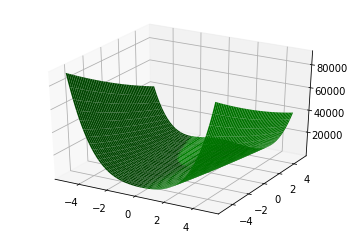

In [110]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, color='g')